In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fusion/final data/CT/p18/ct.jpg
/kaggle/input/fusion/final data/CT/p34/ct.jpg
/kaggle/input/fusion/final data/CT/p17/ct.jpg
/kaggle/input/fusion/final data/CT/p36/ct.jpg
/kaggle/input/fusion/final data/CT/p3/ct.jpg
/kaggle/input/fusion/final data/CT/p35/ct.jpg
/kaggle/input/fusion/final data/CT/p29/ct-10.jpg
/kaggle/input/fusion/final data/CT/p9/ct.jpg
/kaggle/input/fusion/final data/CT/p30/ct.jpg
/kaggle/input/fusion/final data/CT/p10/ct.jpg
/kaggle/input/fusion/final data/CT/p12/ct.jpg
/kaggle/input/fusion/final data/CT/p23/ct-4.jpg
/kaggle/input/fusion/final data/CT/p5/ct.jpg
/kaggle/input/fusion/final data/CT/p15/ct.jpg
/kaggle/input/fusion/final data/CT/p19/ct.jpg
/kaggle/input/fusion/final data/CT/p33/ct.jpg
/kaggle/input/fusion/final data/CT/p1/ct.jpg
/kaggle/input/fusion/final data/CT/p11/ct.jpg
/kaggle/input/fusion/final data/CT/p32/ct.jpg
/kaggle/input/fusion/final data/CT/p2/ct.jpg
/kaggle/input/fusion/final data/CT/p22/ct-3.jpg
/kaggle/input/fusion/final data/

In [2]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# المسارات
main_folder = "/kaggle/input/fusion/final data/CT"
output_folder = "/kaggle/working/ProcessedCT"
os.makedirs(output_folder, exist_ok=True)

# دوال التقييم
def calculate_mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

def calculate_psnr(mse, max_pixel=255.0):
    return 20 * np.log10(max_pixel / np.sqrt(mse)) if mse != 0 else float('inf')

total_images = 0
for folder_name in sorted(os.listdir(main_folder)):
    folder_path = os.path.join(main_folder, folder_name)
    
    if os.path.isdir(folder_path):
        output_subfolder = os.path.join(output_folder, folder_name)
        os.makedirs(output_subfolder, exist_ok=True)

        for image_name in sorted(os.listdir(folder_path)):
            image_path = os.path.join(folder_path, image_name)
            if image_path.lower().endswith(".jpg"):
                try:
                    # 1. تحميل الصورة
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is None:
                        print(f"خطأ: لم يتم تحميل الصورة {image_path}")
                        continue

                    # 2. إعادة تحجيم الصورة إلى 256x256
                    original_image = cv2.resize(image, (256, 256))

                    # 3. تطبيع الصورة (Normalization)
                    image_normalized = cv2.normalize(original_image, None, 0, 255, cv2.NORM_MINMAX)
                    
                    # 4. تحسين إزالة الضوضاء
                    image_denoised = cv2.fastNlMeansDenoising(image_normalized, None, 30, 7, 21)

                    # 5. Gamma Correction ديناميكي
                    mean_intensity = np.mean(image_denoised)
                    gamma = 1.5 if mean_intensity < 100 else 2.0
                    gamma_corrected = np.array(255 * (image_denoised / 255) ** gamma, dtype='uint8')

                    # 6. Histogram Equalization
                    enhanced_image = cv2.equalizeHist(gamma_corrected)

                    # 7. Image Registration باستخدام ORB
                    orb = cv2.ORB_create()
                    keypoints, descriptors = orb.detectAndCompute(enhanced_image, None)
                    # registered_image = cv2.drawKeypoints(enhanced_image, keypoints, None, color=(0, 255, 0))
                    registered_image = enhanced_image.copy()

                    # 8. Edge Detection
                    edges = cv2.Canny(enhanced_image, 70, 150)

                    # 9. حساب معايير التقييم
                    mse_final = calculate_mse(original_image, enhanced_image)
                    psnr_final = calculate_psnr(mse_final)
                    ssim_final = ssim(original_image, enhanced_image)

                    print(f"{image_name} - Final Processed - MSE: {mse_final}, PSNR: {psnr_final}, SSIM: {ssim_final}")
                  # حفظ الصور
                    output_processed_path = os.path.join(output_subfolder, f"{image_name}_processed.jpg")
                    cv2.imwrite(output_processed_path, enhanced_image)

                    output_registered_path = os.path.join(output_subfolder, f"{image_name}_registered.jpg")
                    cv2.imwrite(output_registered_path, registered_image)

                    output_edges_path = os.path.join(output_subfolder, f"{image_name}_edges.jpg")
                    cv2.imwrite(output_edges_path, edges)

                    total_images += 1

                except Exception as e:
                    print(f"خطأ أثناء معالجة الصورة {image_name}: {e}")
                    continue 
print(f"تمت معالجة عدد الصور: {total_images}")

ct.jpg - Final Processed - MSE: 9.520217895507812, PSNR: 38.34433472385356, SSIM: 0.9002752193275846
ct.jpg - Final Processed - MSE: 9.611953735351562, PSNR: 38.302686890949616, SSIM: 0.964227300568369
ct.jpg - Final Processed - MSE: 41.02268981933594, PSNR: 32.000562276196675, SSIM: 0.765462598737356
ct.jpg - Final Processed - MSE: 34.405731201171875, PSNR: 32.764495688276384, SSIM: 0.8102960154751043
ct.jpg - Final Processed - MSE: 34.640533447265625, PSNR: 32.73495789548583, SSIM: 0.8026480967685921
ct.jpg - Final Processed - MSE: 34.78453063964844, PSNR: 32.716942132284586, SSIM: 0.845134793419873
ct.jpg - Final Processed - MSE: 32.40843200683594, PSNR: 33.02422341475688, SSIM: 0.8223763053787889
ct.jpg - Final Processed - MSE: 34.64434814453125, PSNR: 32.73447966648804, SSIM: 0.8385595329055334
ct.jpg - Final Processed - MSE: 28.197006225585938, PSNR: 33.62877360659469, SSIM: 0.8554417032503139
ct.jpg - Final Processed - MSE: 36.61912536621094, PSNR: 32.4937239373578, SSIM: 0.7838

In [3]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

# المسارات
main_folder = "/kaggle/input/fusion/final data/MRI"
output_folder = "/kaggle/working/ProcessedMRI"
os.makedirs(output_folder, exist_ok=True)

# دوال التقييم
def calculate_mse(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

def calculate_psnr(mse, max_pixel=255.0):
    return 20 * np.log10(max_pixel / np.sqrt(mse)) if mse != 0 else float('inf')

# تحسين Bias Field Correction
def bias_field_correction(image):
    rows, cols = image.shape
    x = np.linspace(-1, 1, cols)
    y = np.linspace(-1, 1, rows)
    xv, yv = np.meshgrid(x, y)
    bias_field = 1 + 0.2 * (xv*2 + yv*2)
    blurred_bias = cv2.GaussianBlur(bias_field, (31, 31), 0)
    corrected_image = image / blurred_bias
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    return corrected_image
    
# Skull Stripping
def skull_stripping(image):
    _, binary_mask = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    skull_stripped = cv2.bitwise_and(image, binary_mask)
    return skull_stripped

# Adaptive Min-Max Normalization
def adaptive_min_max_normalization(image):
    p2, p98 = np.percentile(image, (2, 98))
    normalized = cv2.normalize(image, None, p2, p98, cv2.NORM_MINMAX)
    return normalized.astype(np.uint8)

# Noise Reduction (Non-Local Means Denoising)
def noise_reduction(image):
    return cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

# Contrast Enhancement (Gamma Correction)
def gamma_correction(image, gamma=1.02):  # Gamma أقل
    corrected = np.array(255 * (image / 255) ** gamma, dtype='uint8')
    return corrected

# Adaptive Histogram Equalization
def adaptive_histogram_equalization(image):
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))
    return clahe.apply(image)

# Unsharp Masking
def unsharp_mask(image, strength=1.2):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    sharpened = cv2.addWeighted(image, 1 + strength, blurred, -strength, 0)
    return sharpened

# Edge Detection (Canny)
def edge_detection(image):
    return cv2.Canny(image, 40, 100)

# Multi-level Weighted Blending
def multi_level_blending(original, processed, alpha=0.7):
    return cv2.addWeighted(original, alpha, processed, 1 - alpha, 0)

total_images = 0
for folder_name in sorted(os.listdir(main_folder)):
    folder_path = os.path.join(main_folder, folder_name)
    
    if os.path.isdir(folder_path):
        output_subfolder = os.path.join(output_folder, folder_name)
        os.makedirs(output_subfolder, exist_ok=True)

        for image_name in sorted(os.listdir(folder_path)):
            image_path = os.path.join(folder_path, image_name)
            
            if image_path.lower().endswith(".jpg"):
                try:
                    # 1. تحميل الصورة
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    if image is None:
                        print(f"خطأ: لم يتم تحميل الصورة {image_path}")
                        continue
                        
                    # 2. إعادة تحجيم الصورة إلى 256x256
                    original_image = cv2.resize(image, (256, 256))

                    # 3. Bias Field Correction
                    image_bias_corrected = bias_field_correction(original_image)

                    # 4. Skull Stripping
                    image_skull_stripped = skull_stripping(image_bias_corrected)

                    # 5. Adaptive Min-Max Normalization
                    image_normalized = adaptive_min_max_normalization(image_skull_stripped)

                    # 6. Noise Reduction (Non-Local Means)
                    image_denoised = noise_reduction(image_normalized)
                    
                    # 7. Contrast Enhancement
                    image_gamma_corrected = gamma_correction(image_denoised, gamma=1.02)
                    image_contrast_enhanced = adaptive_histogram_equalization(image_gamma_corrected)

                    # 8. Detail Enhancement (Unsharp Masking)
                    image_sharpened = unsharp_mask(image_contrast_enhanced)

                    # 9. Multi-level Weighted Blending
                    blended_image = multi_level_blending(original_image, image_sharpened, alpha=0.7)
                     # . Image Registration باستخدام ORB
                    orb = cv2.ORB_create()
                    keypoints, descriptors = orb.detectAndCompute(blended_image, None)
                    registered_image = blended_image.copy()


                    # 10. Edge Detection (Canny)
                    edges = edge_detection(blended_image)

                    # 11. حساب معايير التقييم
                    mse_final = calculate_mse(original_image, blended_image)
                    psnr_final = calculate_psnr(mse_final)
                    ssim_final = ssim(original_image, blended_image)

                    print(f"{image_name} - Blended - MSE: {mse_final:.2f}, PSNR: {psnr_final:.2f}, SSIM: {ssim_final:.2f}")

                    # حفظ الصور
                    output_processed_path = os.path.join(output_subfolder, f"{image_name}_processed.jpg")
                    cv2.imwrite(output_processed_path, blended_image)

                    output_registered_path = os.path.join(output_subfolder, f"{image_name}_registered.jpg")
                    cv2.imwrite(output_registered_path, registered_image)


                    output_edges_path = os.path.join(output_subfolder, f"{image_name}_edges.jpg")
                    cv2.imwrite(output_edges_path, edges)

                    total_images += 1
                    
                except Exception as e:
                    print(f"خطأ أثناء معالجة الصورة {image_name}: {e}")
                    continue

print(f"تمت معالجة عدد الصور: {total_images}")


mri.jpg - Blended - MSE: 16.16, PSNR: 36.05, SSIM: 0.98
mri.jpg - Blended - MSE: 22.42, PSNR: 34.62, SSIM: 0.97
mri.jpg - Blended - MSE: 32.98, PSNR: 32.95, SSIM: 0.97
mri.jpg - Blended - MSE: 21.99, PSNR: 34.71, SSIM: 0.92
mri.jpg - Blended - MSE: 15.46, PSNR: 36.24, SSIM: 0.96
mri.jpg - Blended - MSE: 20.93, PSNR: 34.92, SSIM: 0.96
mri.jpg - Blended - MSE: 15.88, PSNR: 36.12, SSIM: 0.99
mri.jpg - Blended - MSE: 25.77, PSNR: 34.02, SSIM: 0.96
mri.jpg - Blended - MSE: 11.92, PSNR: 37.37, SSIM: 0.96
mri.jpg - Blended - MSE: 27.02, PSNR: 33.81, SSIM: 0.97
mri.jpg - Blended - MSE: 13.86, PSNR: 36.71, SSIM: 0.95
mri.jpg - Blended - MSE: 14.93, PSNR: 36.39, SSIM: 0.92
mri.jpg - Blended - MSE: 19.55, PSNR: 35.22, SSIM: 0.96
mri_2.jpg - Blended - MSE: 18.61, PSNR: 35.43, SSIM: 0.94
mri-2.jpg - Blended - MSE: 19.79, PSNR: 35.17, SSIM: 0.95
mri-3.jpg - Blended - MSE: 16.72, PSNR: 35.90, SSIM: 0.95
mri-4.jpg - Blended - MSE: 7.62, PSNR: 39.31, SSIM: 0.90
mri-5.jpg - Blended - MSE: 33.92, PSNR: 3

In [4]:
import os
import cv2

# تحديد المسارات لمجلدات الصور
ct_path = '/kaggle/input/fusion/final data/CT'   
mri_path = '/kaggle/input/fusion/final data/MRI'  

# دالة لقراءة الصور من المجلدات الفرعية
def load_images_from_subfolders(base_path):
    images = []
    for subfolder in os.listdir(base_path):
        subfolder_path = os.path.join(base_path, subfolder)
        if os.path.isdir(subfolder_path):  # إذا كان المجلد فرعي
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.png') or filename.endswith('.jpg'):  # إذا كانت الصورة بصيغة .png أو .jpg
                    img_path = os.path.join(subfolder_path, filename)
                    image = cv2.imread(img_path, 0)  # قراءة الصورة باللون الرمادي
                    images.append(image)
    return images

# قراءة الصور من المجلدات الفرعية
ct_images = load_images_from_subfolders(ct_path)
mri_images = load_images_from_subfolders(mri_path)

# التأكد من عدد الصور
assert len(ct_images) == 38, "عدد صور CT ليس صحيح"
assert len(mri_images) == 40, "عدد صور MRI ليس صحيح"

print(f"تم تحميل {len(ct_images)} صورة CT و {len(mri_images)} صورة MRI.")


تم تحميل 38 صورة CT و 40 صورة MRI.


In [5]:
import pywt
import numpy as np

# دالة لتطبيق CWT باستخدام Haar wavelet
def apply_cwt(image):
    coeffs = pywt.dwt2(image, 'haar')  # تطبيق DWT باستخدام Haar wavelet
    return coeffs

# تطبيق CWT على أول صورة من CT وأول صورة من MRI كمثال
ct_cwt = apply_cwt(ct_images[0])
mri_cwt = apply_cwt(mri_images[0])

print(f"تم تطبيق CWT على صورة CT وصورة MRI الأولى.")


تم تطبيق CWT على صورة CT وصورة MRI الأولى.


In [6]:
# دالة لدمج الصور باستخدام CWT
def fuse_images(ct_image, mri_image):
    ct_cwt = apply_cwt(ct_image)
    mri_cwt = apply_cwt(mri_image)
    
    # استخراج المكونات (cA: المكون التقريبي، cH: التفاصيل الأفقية، cV: التفاصيل الرأسية، cD: التفاصيل القطبية)
    cA_ct, (cH_ct, cV_ct, cD_ct) = ct_cwt
    cA_mri, (cH_mri, cV_mri, cD_mri) = mri_cwt
    
    # دمج المكونات: استخدام تقنية Max Fusion (اختيار أكبر التفاصيل)
    merged_cA = np.maximum(cA_ct, cA_mri)
    merged_cH = np.maximum(cH_ct, cH_mri)
    merged_cV = np.maximum(cV_ct, cV_mri)
    merged_cD = np.maximum(cD_ct, cD_mri)
    
    # إعادة تشكيل المكونات المدمجة
    merged_cwt = (merged_cA, (merged_cH, merged_cV, merged_cD))
    
    return merged_cwt

# دمج أول صورة من CT مع أول صورة من MRI كمثال
merged_cwt = fuse_images(ct_images[0], mri_images[0])

print(f"تم دمج الصور باستخدام CWT.")


تم دمج الصور باستخدام CWT.


عدد الصور المشتركة للدمج: 38


  0%|          | 0/38 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/tmp/ipykernel_30/1399757554.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  cwt_result[i, :] = np.mean(coeffs, axis=0)
100%|██████████| 38/38 [01:47<00:00,  2.84s/it]


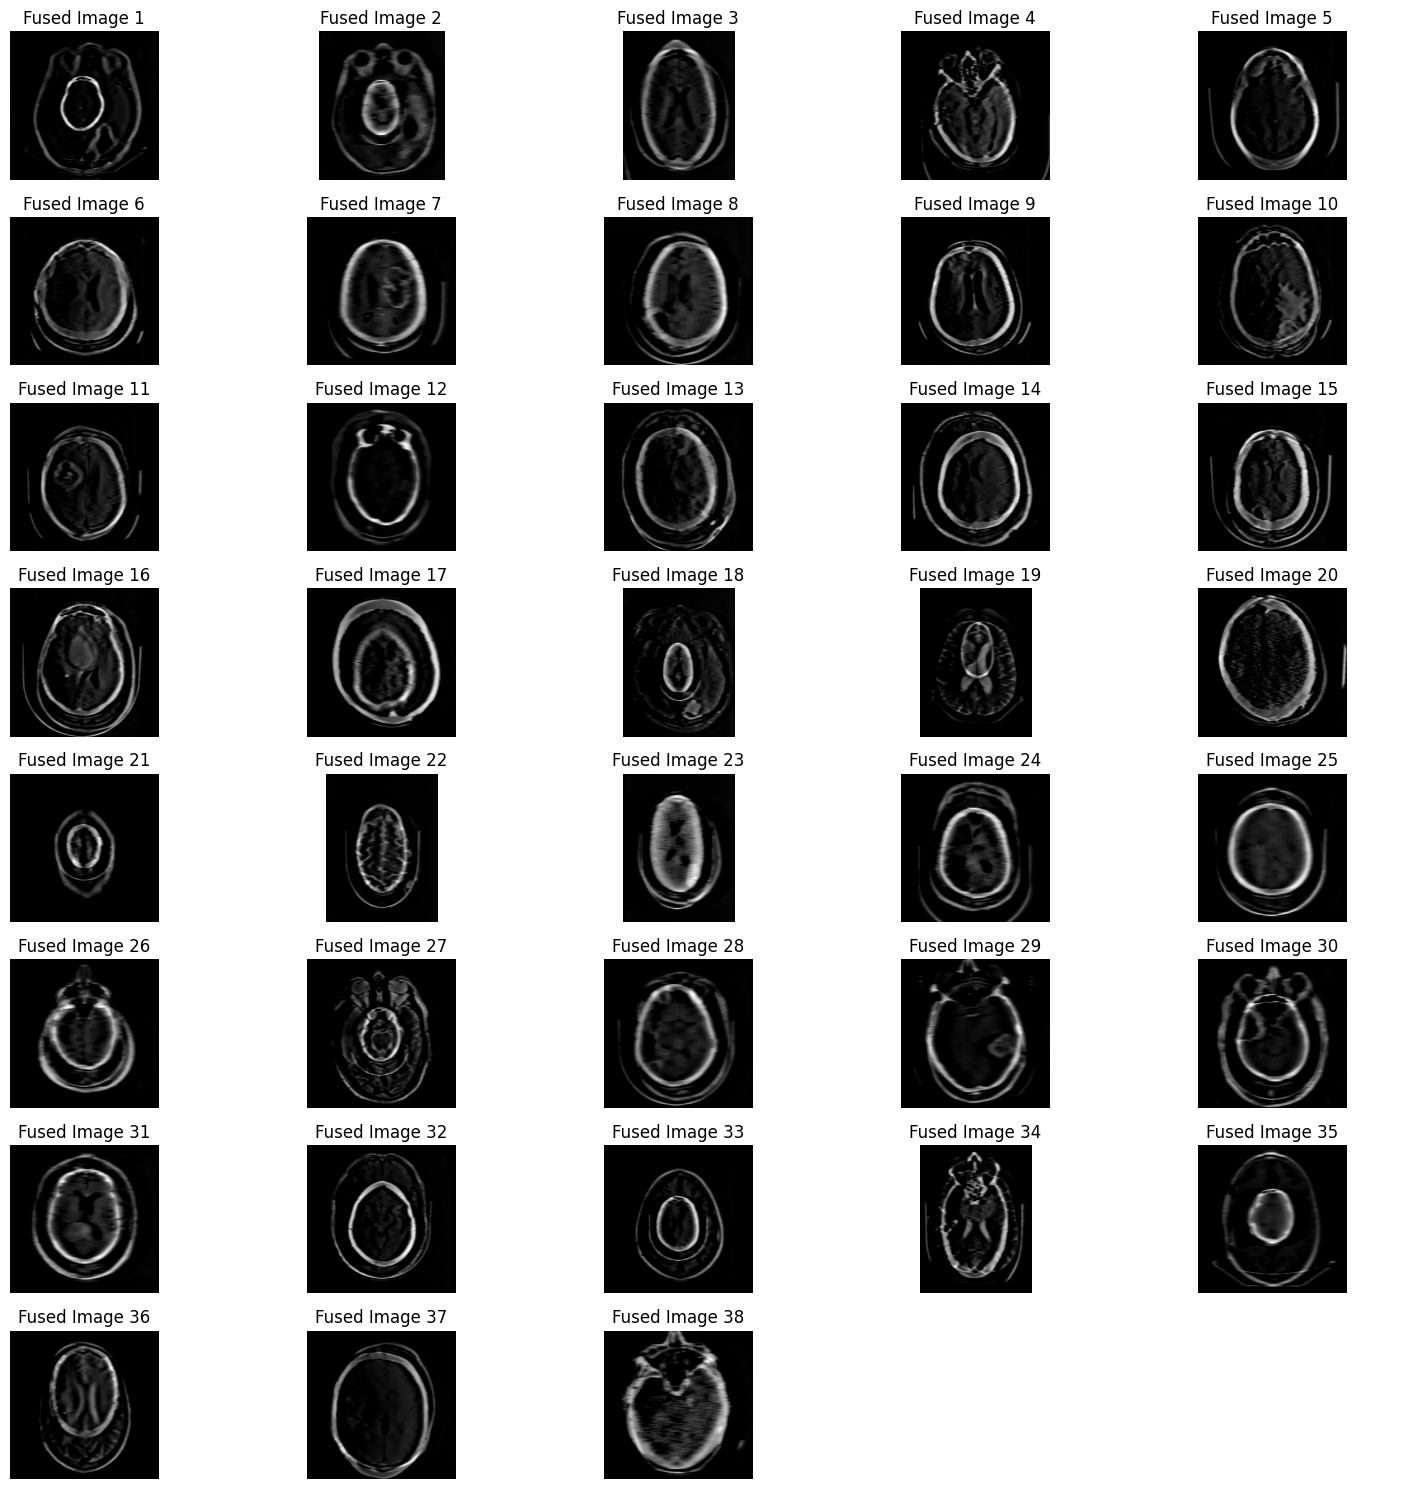

تم دمج 38 صورة وحفظ النتائج في: /kaggle/working/


In [7]:
import os
import cv2
import pywt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# دالة لاستعراض جميع الملفات داخل المجلدات الفرعية
def get_all_images(folder, extensions=('.png', '.jpg', '.jpeg')):
    image_paths = []
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))
    return sorted(image_paths)

# دالة لتطبيق CWT يدويًا
def apply_cwt(image, wavelet='cmor', scales=np.arange(1, 31)):
    rows, cols = image.shape
    cwt_result = np.zeros_like(image, dtype=float)
    for i in range(rows):
        row = image[i, :]
        coeffs, _ = pywt.cwt(row, scales, wavelet)
        cwt_result[i, :] = np.mean(coeffs, axis=0)
    return cwt_result

# دالة لإعادة بناء الصورة باستخدام DWT
def inverse_dwt(coeffs):
    return pywt.idwt2(coeffs, 'haar')

# المسارات للمجلدين
mri_folder = "/kaggle/input/fusion/final data/MRI"
ct_folder = "/kaggle/input/fusion/final data/CT"
output_folder = "/kaggle/working/"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# الحصول على جميع الصور من المجلدات الفرعية
mri_images = get_all_images(mri_folder)
ct_images = get_all_images(ct_folder)

# استخدام العدد الأقل من الصور بين المجلدين
num_images = min(len(mri_images), len(ct_images))
print(f"عدد الصور المشتركة للدمج: {num_images}")

# قائمة لحفظ الصور الناتجة
fused_images = []

# تنفيذ عملية الدمج على الصور المشتركة
for i, (mri_path, ct_path) in enumerate(tqdm(zip(mri_images[:num_images], ct_images[:num_images]), total=num_images)):
    # قراءة الصور باللون الرمادي
    mri_image = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
    ct_image = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)

    # تغيير حجم الصور لتكون متساوية
    if mri_image.shape != ct_image.shape:
        ct_image = cv2.resize(ct_image, (mri_image.shape[1], mri_image.shape[0]))

    # تطبيق CWT
    cwt_mri = apply_cwt(mri_image)
    cwt_ct = apply_cwt(ct_image)

    # دمج النتائج
    merged_cwt = (cwt_mri + cwt_ct) / 2

    # إعادة بناء الصورة المدمجة
    fused_image = np.clip(merged_cwt, 0, 255)  # ضبط القيم بين 0 و255
    fused_images.append(fused_image)

    # حفظ الصورة المدمجة
    output_path = os.path.join(output_folder, f"fused_image_{i+1}.png")
    cv2.imwrite(output_path, fused_image.astype(np.uint8))

# عرض جميع الصور باستخدام شبكة
fig, axes = plt.subplots(nrows=int(np.ceil(num_images / 5)), ncols=5, figsize=(15, 15))

for idx, ax in enumerate(axes.flat):
    if idx < len(fused_images):
        ax.imshow(fused_images[idx], cmap='gray')
        ax.set_title(f"Fused Image {idx+1}")
        ax.axis('off')
    else:
        ax.axis('off')  # إخفاء المحاور الفارغة

plt.tight_layout()
plt.show()

print(f"تم دمج {num_images} صورة وحفظ النتائج في: {output_folder}")


In [8]:
import os
import cv2
import numpy as np
import pywt
from tqdm import tqdm

# دالة لتغيير حجم الصورة إلى نفس حجم صورة CT
def resize_image_to_match(ct_image, mri_image):
    # تغيير حجم صورة MRI لتتناسب مع حجم صورة CT
    resized_mri_image = cv2.resize(mri_image, (ct_image.shape[1], ct_image.shape[0]))
    return resized_mri_image

# دالة لتطبيق CWT على صورة
def apply_cwt(image, wavelet='haar'):
    cA, (cH, cV, cD) = pywt.dwt2(image, wavelet)
    return cA, (cH, cV, cD)

# دالة لإعادة بناء الصورة باستخدام Inverse CWT
def inverse_cwt(coeffs):
    return pywt.idwt2(coeffs, 'haar')

# دالة لدمج الصور باستخدام CWT
def fuse_images(ct_image, mri_image):
    # تغيير حجم صورة MRI لتتناسب مع حجم صورة CT
    mri_image_resized = resize_image_to_match(ct_image, mri_image)
    
    # تطبيق CWT على كل من CT و MRI
    ct_cwt = apply_cwt(ct_image)
    mri_cwt = apply_cwt(mri_image_resized)
    
    # استخراج المكونات (cA: المكون التقريبي، cH: التفاصيل الأفقية، cV: التفاصيل الرأسية، cD: التفاصيل القطبية)
    cA_ct, (cH_ct, cV_ct, cD_ct) = ct_cwt
    cA_mri, (cH_mri, cV_mri, cD_mri)  = mri_cwt
    
    # دمج المكونات: استخدام تقنية Max Fusion (اختيار أكبر التفاصيل)
    merged_cA = np.maximum(cA_ct, cA_mri)
    merged_cH = np.maximum(cH_ct, cH_mri)
    merged_cV = np.maximum(cV_ct, cV_mri)
    merged_cD = np.maximum(cD_ct, cD_mri)
    
    # إعادة تشكيل المكونات المدمجة
    merged_cwt = (merged_cA, (merged_cH, merged_cV, merged_cD))
    
    return merged_cwt

# المسارات إلى المجلدات
ct_folder = "/kaggle/input/fusion/final data/CT"
mri_folder = "/kaggle/input/fusion/final data/MRI"
output_folder = "/kaggle/working/"
os.makedirs(output_folder, exist_ok=True)

# جمع جميع الصور من المجلدات
ct_images = sorted([os.path.join(ct_folder, f) for f in os.listdir(ct_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
mri_images = sorted([os.path.join(mri_folder, f) for f in os.listdir(mri_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

# التأكد من توافق عدد الصور
num_images = min(len(ct_images), len(mri_images))
ct_images = ct_images[:num_images]
mri_images = mri_images[:num_images]

# دمج الصور واحدة تلو الأخرى
for i, (ct_img_path, mri_img_path) in enumerate(tqdm(zip(ct_images, mri_images), total=num_images)):
    # قراءة الصور
    ct_image = cv2.imread(ct_img_path, cv2.IMREAD_GRAYSCALE)
    mri_image = cv2.imread(mri_img_path, cv2.IMREAD_GRAYSCALE)
    
    # دمج الصور باستخدام CWT
    fused_cwt = fuse_images(ct_image, mri_image)
    final_fused_image = inverse_cwt(fused_cwt)
    
    # حفظ الصورة المدمجة
    output_path = os.path.join(output_folder, f'fused_image_{i+1}.png')
    cv2.imwrite(output_path, np.clip(final_fused_image, 0, 255).astype(np.uint8))
    print(f"تم حفظ الصورة المدمجة {i+1} في {output_path}")

print("تم دمج جميع الصور وحفظها بنجاح.")


0it [00:00, ?it/s]

تم دمج جميع الصور وحفظها بنجاح.


In [12]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr, mean_squared_error as mse
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import matplotlib.pyplot as plt

# دالة لقراءة الصور من الملفات الفرعية
def load_images_from_subfolders(folder_path, target_size=None):
    images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_path = os.path.join(subdir, file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # قراءة الصور كصور رمادية
                if target_size:  # إذا كانت الأبعاد المستهدفة محددة
                    image = cv2.resize(image, target_size)
                images.append(image)
    return images

# مسارات المجلدات الرئيسية
ct_folder = '/kaggle/input/fusion/final data/CT'
mri_folder = '/kaggle/input/fusion/final data/MRI'

# تحديد الأبعاد المستهدفة (بناءً على صورة CT الأولى)
target_size = (256, 256)  # يمكن ضبط الأبعاد حسب الحاجة

# تحميل الصور
ct_images = load_images_from_subfolders(ct_folder, target_size=target_size)
mri_images = load_images_from_subfolders(mri_folder, target_size=target_size)

# تحديد العدد الأقل من الصور
min_images = min(len(ct_images), len(mri_images))

# اقتصاص الصور إلى العدد الأقل
ct_images = ct_images[:min_images]
mri_images = mri_images[:min_images]

# دوال لحساب المقاييس
def calculate_metrics(img1, img2):
    metrics = {}
    
    # حساب SSIM
    metrics['SSIM'] = ssim(img1, img2)
    
    # حساب PSNR
    metrics['PSNR'] = psnr(img1, img2)
    
    # حساب MSE
    metrics['MSE'] = mse(img1, img2)
    
    # حساب Mutual Information (MI)
    hist_2d, _, _ = np.histogram2d(img1.ravel(), img2.ravel(), bins=20)
    metrics['MI'] = mutual_info_score(None, None, contingency=hist_2d)
    
    # حساب Mean Intensity
    metrics['Mean Intensity 1'] = np.mean(img1)
    metrics['Mean Intensity 2'] = np.mean(img2)
    
    # حساب Std Dev
    metrics['Std Dev 1'] = np.std(img1)
    metrics['Std Dev 2'] = np.std(img2)
    
    # حساب Entropy
    metrics['Entropy 1'] = entropy(np.histogram(img1.ravel(), bins=256)[0])
    metrics['Entropy 2'] = entropy(np.histogram(img2.ravel(), bins=256)[0])
    
    return metrics

# حساب المقاييس لكل زوج من الصور
all_metrics = []
for i, (ct_image, mri_image) in enumerate(zip(ct_images, mri_images)):
    print(f"حساب المقاييس للصورة رقم {i+1}...")
    metrics = calculate_metrics(ct_image, mri_image)
    all_metrics.append(metrics)

# عرض النتائج
for i, metrics in enumerate(all_metrics):
    print(f"\nنتائج الصورة {i+1}:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")


حساب المقاييس للصورة رقم 1...
حساب المقاييس للصورة رقم 2...
حساب المقاييس للصورة رقم 3...
حساب المقاييس للصورة رقم 4...
حساب المقاييس للصورة رقم 5...
حساب المقاييس للصورة رقم 6...
حساب المقاييس للصورة رقم 7...
حساب المقاييس للصورة رقم 8...
حساب المقاييس للصورة رقم 9...
حساب المقاييس للصورة رقم 10...
حساب المقاييس للصورة رقم 11...
حساب المقاييس للصورة رقم 12...
حساب المقاييس للصورة رقم 13...
حساب المقاييس للصورة رقم 14...
حساب المقاييس للصورة رقم 15...
حساب المقاييس للصورة رقم 16...
حساب المقاييس للصورة رقم 17...
حساب المقاييس للصورة رقم 18...
حساب المقاييس للصورة رقم 19...
حساب المقاييس للصورة رقم 20...
حساب المقاييس للصورة رقم 21...
حساب المقاييس للصورة رقم 22...
حساب المقاييس للصورة رقم 23...
حساب المقاييس للصورة رقم 24...
حساب المقاييس للصورة رقم 25...
حساب المقاييس للصورة رقم 26...
حساب المقاييس للصورة رقم 27...
حساب المقاييس للصورة رقم 28...
حساب المقاييس للصورة رقم 29...
حساب المقاييس للصورة رقم 30...
حساب المقاييس للصورة رقم 31...
حساب المقاييس للصورة رقم 32...
حساب المقاييس للص

In [ ]:
# DWT 